# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [43]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [44]:
train, test = keras.datasets.cifar10.load_data()

In [58]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        
    x=2*(x-x.min())/(x.max()-x.min())-1
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [59]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [65]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [66]:
## 超參數設定
#LEARNING_RATE = 0.001
LEARNING_RATE = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
#LEARNING_RATE = [1e-1]
EPOCHS = 100
BATCH_SIZE = 256
MOMENTUM = 0.95


In [67]:
results = {}
optimizer = {}
for lr in LEARNING_RATE:
    exp_name_tag = "Adam_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':(keras.optimizers.Adam(lr=lr))}
    exp_name_tag = "SGD_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':keras.optimizers.SGD(lr=lr)}
    #optimizer[exp_name_tag]={'optimizer':keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)}
    exp_name_tag = "RMS_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':keras.optimizers.RMSprop(lr=lr)}
    exp_name_tag = "AdaGrad_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':keras.optimizers.Adagrad(lr=lr)}

for i,opt in enumerate(optimizer.keys()):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer[opt]['optimizer'])
    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    results[list(optimizer.keys())[i]] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 184us/step - loss: 1.6710 - acc: 0.4093 - val_loss: 1.5317 - val_acc: 0.4572
Epoch 2/100
50000/50000 [==============================] - 5s 109us/step - loss: 1.4418 - acc: 0.4930 - val_loss: 1.4277 - val_acc: 0.5018
Epoch 3/100
50000/50000 [==============================] - 6s 120us/step - loss: 1.3217 - acc: 0.5356 - val_loss: 1.3879 - val_acc: 0.5223
Epoch 4/100
50000/50000 [==============================] - 6s 119us/step - loss: 1.2229 - acc: 0.5704 - val_loss: 1.3795 - val_acc: 0.5171
Epoch 5/100
50000/50000 [==============================] - 6s 118us/step - loss: 1.1355 - acc: 0.5995 - val_loss: 1.3587 - val_acc: 0.5320
Epoch 6/100
50000/50000 [==============================] - 6s 114us/step - loss: 1.0545 - acc: 0.6278 - val_loss: 1.3849 - val_acc: 0.5327
Epoch 7/100
50000/50000 [==============================] - 6s 119us/step - loss: 0.9794 - acc: 0.6554 - val_loss: 1.

50000/50000 [==============================] - 6s 115us/step - loss: 0.0930 - acc: 0.9695 - val_loss: 4.1210 - val_acc: 0.5263
Epoch 60/100
50000/50000 [==============================] - 6s 116us/step - loss: 0.1290 - acc: 0.9597 - val_loss: 3.9770 - val_acc: 0.5187
Epoch 61/100
50000/50000 [==============================] - 6s 113us/step - loss: 0.1198 - acc: 0.9613 - val_loss: 3.9516 - val_acc: 0.5211
Epoch 62/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.0881 - acc: 0.9707 - val_loss: 4.0795 - val_acc: 0.5253
Epoch 63/100
50000/50000 [==============================] - 5s 109us/step - loss: 0.0884 - acc: 0.9722 - val_loss: 4.0924 - val_acc: 0.5227
Epoch 64/100
50000/50000 [==============================] - 6s 110us/step - loss: 0.0979 - acc: 0.9693 - val_loss: 3.9743 - val_acc: 0.5300
Epoch 65/100
50000/50000 [==============================] - 6s 112us/step - loss: 0.1041 - acc: 0.9659 - val_loss: 4.0526 - val_acc: 0.5332
Epoch 66/100
50000/50000 [=======

50000/50000 [==============================] - 3s 69us/step - loss: 0.0164 - acc: 0.9953 - val_loss: 4.3389 - val_acc: 0.5318
Epoch 18/100
50000/50000 [==============================] - 3s 69us/step - loss: 0.0157 - acc: 0.9955 - val_loss: 4.3394 - val_acc: 0.5317
Epoch 19/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0151 - acc: 0.9958 - val_loss: 4.3403 - val_acc: 0.5317
Epoch 20/100
50000/50000 [==============================] - 3s 70us/step - loss: 0.0145 - acc: 0.9961 - val_loss: 4.3414 - val_acc: 0.5319
Epoch 21/100
50000/50000 [==============================] - 3s 69us/step - loss: 0.0140 - acc: 0.9962 - val_loss: 4.3417 - val_acc: 0.5319
Epoch 22/100
50000/50000 [==============================] - 3s 69us/step - loss: 0.0135 - acc: 0.9965 - val_loss: 4.3427 - val_acc: 0.5316
Epoch 23/100
50000/50000 [==============================] - 4s 71us/step - loss: 0.0131 - acc: 0.9967 - val_loss: 4.3439 - val_acc: 0.5323
Epoch 24/100
50000/50000 [==============

50000/50000 [==============================] - 3s 69us/step - loss: 0.0052 - acc: 0.9995 - val_loss: 4.4085 - val_acc: 0.5342
Epoch 77/100
50000/50000 [==============================] - 3s 67us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 4.4094 - val_acc: 0.5341
Epoch 78/100
50000/50000 [==============================] - 3s 67us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 4.4105 - val_acc: 0.5344
Epoch 79/100
50000/50000 [==============================] - 3s 68us/step - loss: 0.0050 - acc: 0.9996 - val_loss: 4.4116 - val_acc: 0.5347
Epoch 80/100
50000/50000 [==============================] - 3s 68us/step - loss: 0.0050 - acc: 0.9996 - val_loss: 4.4127 - val_acc: 0.5348
Epoch 81/100
50000/50000 [==============================] - 3s 68us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 4.4137 - val_acc: 0.5346
Epoch 82/100
50000/50000 [==============================] - 3s 67us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 4.4149 - val_acc: 0.5346
Epoch 83/100
50000/50000 [==============

50000/50000 [==============================] - 5s 107us/step - loss: 0.0641 - acc: 0.9836 - val_loss: 5.3089 - val_acc: 0.5270
Epoch 35/100
50000/50000 [==============================] - 5s 99us/step - loss: 0.0516 - acc: 0.9863 - val_loss: 5.3128 - val_acc: 0.5340
Epoch 36/100
50000/50000 [==============================] - 5s 102us/step - loss: 0.0627 - acc: 0.9847 - val_loss: 5.3366 - val_acc: 0.5281
Epoch 37/100
50000/50000 [==============================] - 5s 99us/step - loss: 0.0590 - acc: 0.9854 - val_loss: 5.3094 - val_acc: 0.5274
Epoch 38/100
50000/50000 [==============================] - 5s 109us/step - loss: 0.0517 - acc: 0.9862 - val_loss: 5.4122 - val_acc: 0.5213
Epoch 39/100
50000/50000 [==============================] - 5s 102us/step - loss: 0.0550 - acc: 0.9857 - val_loss: 5.3593 - val_acc: 0.5214
Epoch 40/100
50000/50000 [==============================] - 5s 101us/step - loss: 0.0628 - acc: 0.9844 - val_loss: 5.3664 - val_acc: 0.5306
Epoch 41/100
50000/50000 [=========

Epoch 93/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.0564 - acc: 0.9869 - val_loss: 5.8446 - val_acc: 0.5254
Epoch 94/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0617 - acc: 0.9863 - val_loss: 5.7875 - val_acc: 0.5263
Epoch 95/100
50000/50000 [==============================] - 5s 101us/step - loss: 0.0563 - acc: 0.9871 - val_loss: 5.8313 - val_acc: 0.5229
Epoch 96/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0560 - acc: 0.9875 - val_loss: 5.8287 - val_acc: 0.5251
Epoch 97/100
50000/50000 [==============================] - 5s 100us/step - loss: 0.0561 - acc: 0.9875 - val_loss: 5.8076 - val_acc: 0.5283
Epoch 98/100
50000/50000 [==============================] - 5s 101us/step - loss: 0.0516 - acc: 0.9884 - val_loss: 5.8212 - val_acc: 0.5266
Epoch 99/100
50000/50000 [==============================] - 5s 99us/step - loss: 0.0575 - acc: 0.9877 - val_loss: 5.8304 - val_acc: 0.5288
Epoch 100/100
50000/500

50000/50000 [==============================] - 4s 77us/step - loss: 3.5389e-04 - acc: 1.0000 - val_loss: 5.7693 - val_acc: 0.5342
Epoch 51/100
50000/50000 [==============================] - 4s 76us/step - loss: 3.5347e-04 - acc: 1.0000 - val_loss: 5.7695 - val_acc: 0.5341
Epoch 52/100
50000/50000 [==============================] - 4s 77us/step - loss: 3.5307e-04 - acc: 1.0000 - val_loss: 5.7697 - val_acc: 0.5342
Epoch 53/100
50000/50000 [==============================] - 4s 76us/step - loss: 3.5268e-04 - acc: 1.0000 - val_loss: 5.7698 - val_acc: 0.5343
Epoch 54/100
50000/50000 [==============================] - 4s 77us/step - loss: 3.5231e-04 - acc: 1.0000 - val_loss: 5.7700 - val_acc: 0.5344
Epoch 55/100
50000/50000 [==============================] - 4s 78us/step - loss: 3.5194e-04 - acc: 1.0000 - val_loss: 5.7701 - val_acc: 0.5344
Epoch 56/100
50000/50000 [==============================] - 4s 76us/step - loss: 3.5158e-04 - acc: 1.0000 - val_loss: 5.7703 - val_acc: 0.5344
Epoch 57/100

50000/50000 [==============================] - 5s 107us/step - loss: 9.5582e-06 - acc: 1.0000 - val_loss: 5.8064 - val_acc: 0.5386
Epoch 8/100
50000/50000 [==============================] - 5s 102us/step - loss: 7.8928e-06 - acc: 1.0000 - val_loss: 5.8078 - val_acc: 0.5388
Epoch 9/100
50000/50000 [==============================] - 5s 103us/step - loss: 6.8836e-06 - acc: 1.0000 - val_loss: 5.8092 - val_acc: 0.5383
Epoch 10/100
50000/50000 [==============================] - 5s 104us/step - loss: 6.1325e-06 - acc: 1.0000 - val_loss: 5.8108 - val_acc: 0.5383
Epoch 11/100
50000/50000 [==============================] - 5s 103us/step - loss: 5.5443e-06 - acc: 1.0000 - val_loss: 5.8125 - val_acc: 0.5385
Epoch 12/100
50000/50000 [==============================] - 5s 103us/step - loss: 5.0441e-06 - acc: 1.0000 - val_loss: 5.8141 - val_acc: 0.5387
Epoch 13/100
50000/50000 [==============================] - 5s 103us/step - loss: 4.6076e-06 - acc: 1.0000 - val_loss: 5.8159 - val_acc: 0.5391
Epoch 1

Epoch 64/100
50000/50000 [==============================] - 5s 104us/step - loss: 2.2767e-07 - acc: 1.0000 - val_loss: 5.9313 - val_acc: 0.5422
Epoch 65/100
50000/50000 [==============================] - 6s 111us/step - loss: 2.2101e-07 - acc: 1.0000 - val_loss: 5.9336 - val_acc: 0.5422
Epoch 66/100
50000/50000 [==============================] - 5s 109us/step - loss: 2.1326e-07 - acc: 1.0000 - val_loss: 5.9360 - val_acc: 0.5420
Epoch 67/100
50000/50000 [==============================] - 5s 102us/step - loss: 2.0593e-07 - acc: 1.0000 - val_loss: 5.9389 - val_acc: 0.5423
Epoch 68/100
50000/50000 [==============================] - 6s 110us/step - loss: 2.0070e-07 - acc: 1.0000 - val_loss: 5.9407 - val_acc: 0.5423
Epoch 69/100
50000/50000 [==============================] - 5s 107us/step - loss: 1.9493e-07 - acc: 1.0000 - val_loss: 5.9437 - val_acc: 0.5422
Epoch 70/100
50000/50000 [==============================] - 5s 109us/step - loss: 1.8910e-07 - acc: 1.0000 - val_loss: 5.9460 - val_acc:

Epoch 21/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 22/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 23/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 24/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 25/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 26/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 27/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415

50000/50000 [==============================] - 3s 69us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 79/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 80/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 81/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 82/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 83/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 84/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.2541e-07 - acc: 1.0000 - val_loss: 6.0180 - val_acc: 0.5415
Epoch 85/100

50000/50000 [==============================] - 4s 90us/step - loss: 1.1962e-07 - acc: 1.0000 - val_loss: 6.0773 - val_acc: 0.5417
Epoch 36/100
50000/50000 [==============================] - 5s 90us/step - loss: 1.1959e-07 - acc: 1.0000 - val_loss: 6.0779 - val_acc: 0.5417
Epoch 37/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1958e-07 - acc: 1.0000 - val_loss: 6.0789 - val_acc: 0.5416
Epoch 38/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1956e-07 - acc: 1.0000 - val_loss: 6.0797 - val_acc: 0.5416
Epoch 39/100
50000/50000 [==============================] - 4s 88us/step - loss: 1.1955e-07 - acc: 1.0000 - val_loss: 6.0800 - val_acc: 0.5416
Epoch 40/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1953e-07 - acc: 1.0000 - val_loss: 6.0808 - val_acc: 0.5418
Epoch 41/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1952e-07 - acc: 1.0000 - val_loss: 6.0811 - val_acc: 0.5417
Epoch 42/100

50000/50000 [==============================] - 4s 89us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0971 - val_acc: 0.5417
Epoch 93/100
50000/50000 [==============================] - 4s 90us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0973 - val_acc: 0.5416
Epoch 94/100
50000/50000 [==============================] - 4s 90us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0975 - val_acc: 0.5418
Epoch 95/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0976 - val_acc: 0.5416
Epoch 96/100
50000/50000 [==============================] - 4s 90us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0978 - val_acc: 0.5415
Epoch 97/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0980 - val_acc: 0.5417
Epoch 98/100
50000/50000 [==============================] - 4s 90us/step - loss: 1.1925e-07 - acc: 1.0000 - val_loss: 6.0981 - val_acc: 0.5418
Epoch 99/100

50000/50000 [==============================] - 4s 75us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1009 - val_acc: 0.5417
Epoch 50/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1009 - val_acc: 0.5416
Epoch 51/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1009 - val_acc: 0.5416
Epoch 52/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1010 - val_acc: 0.5416
Epoch 53/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1010 - val_acc: 0.5416
Epoch 54/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1010 - val_acc: 0.5416
Epoch 55/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1922e-07 - acc: 1.0000 - val_loss: 6.1010 - val_acc: 0.5416
Epoch 56/100

50000/50000 [==============================] - 5s 98us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1021 - val_acc: 0.5416
Epoch 7/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1021 - val_acc: 0.5416
Epoch 8/100
50000/50000 [==============================] - 5s 94us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1021 - val_acc: 0.5416
Epoch 9/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1022 - val_acc: 0.5416
Epoch 10/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1022 - val_acc: 0.5416
Epoch 11/100
50000/50000 [==============================] - 5s 95us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1022 - val_acc: 0.5415
Epoch 12/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1022 - val_acc: 0.5416
Epoch 13/100
5

50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 64/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 65/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 66/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 67/100
50000/50000 [==============================] - 5s 95us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 68/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 69/100
50000/50000 [==============================] - 5s 95us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1024 - val_acc: 0.5416
Epoch 70/100

50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 21/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 22/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 23/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 24/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 25/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 26/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 27/100

50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 78/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 79/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 80/100
50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 81/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 82/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 83/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1025 - val_acc: 0.5416
Epoch 84/100

50000/50000 [==============================] - 5s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 35/100
50000/50000 [==============================] - 5s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 36/100
50000/50000 [==============================] - 5s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 37/100
50000/50000 [==============================] - 5s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 38/100
50000/50000 [==============================] - 4s 90us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 39/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 40/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1027 - val_acc: 0.5416
Epoch 41/100

50000/50000 [==============================] - 5s 94us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 92/100
50000/50000 [==============================] - 5s 97us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 93/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 94/100
50000/50000 [==============================] - 5s 97us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 95/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 96/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 97/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1029 - val_acc: 0.5417
Epoch 98/100

50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5416
Epoch 49/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5416
Epoch 50/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5416
Epoch 51/100
50000/50000 [==============================] - 4s 75us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5416
Epoch 52/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5415
Epoch 53/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5415
Epoch 54/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1030 - val_acc: 0.5416
Epoch 55/100

50000/50000 [==============================] - 5s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 6/100
50000/50000 [==============================] - 5s 103us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 7/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 8/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 9/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 10/100
50000/50000 [==============================] - 5s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 11/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5413
Epoch 12/10

50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 63/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 64/100
50000/50000 [==============================] - 5s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 65/100
50000/50000 [==============================] - 5s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 66/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 67/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 68/100
50000/50000 [==============================] - 5s 99us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 69/10

Epoch 19/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 20/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 21/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 22/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 23/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 24/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 25/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414

50000/50000 [==============================] - 3s 65us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 77/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 78/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 79/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 80/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 81/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 82/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 83/100

50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 34/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 35/100
50000/50000 [==============================] - 5s 91us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 36/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 37/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 38/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 39/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1031 - val_acc: 0.5414
Epoch 40/100

50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 91/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 92/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 93/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 94/100
50000/50000 [==============================] - 5s 92us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 95/100
50000/50000 [==============================] - 5s 91us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 96/100
50000/50000 [==============================] - 5s 93us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 97/100

50000/50000 [==============================] - 4s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 48/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 49/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 50/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 51/100
50000/50000 [==============================] - 4s 76us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 52/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 53/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 54/100

50000/50000 [==============================] - 5s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 5/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 6/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 7/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 8/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 9/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 10/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 11/1

50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 62/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 63/100
50000/50000 [==============================] - 5s 107us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 64/100
50000/50000 [==============================] - 5s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 65/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 66/100
50000/50000 [==============================] - 5s 106us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 67/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch

Epoch 18/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 19/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 20/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 21/100
50000/50000 [==============================] - 4s 72us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 22/100
50000/50000 [==============================] - 4s 70us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 23/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 24/100
50000/50000 [==============================] - 3s 68us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414

50000/50000 [==============================] - 3s 68us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 76/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 77/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 78/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 79/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 80/100
50000/50000 [==============================] - 3s 69us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 81/100
50000/50000 [==============================] - 3s 67us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 82/100

Epoch 32/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 33/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 34/100
50000/50000 [==============================] - 5s 106us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 35/100
50000/50000 [==============================] - 6s 111us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 36/100
50000/50000 [==============================] - 5s 107us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 37/100
50000/50000 [==============================] - 6s 116us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 38/100
50000/50000 [==============================] - 5s 109us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc:

Epoch 89/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 90/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 91/100
50000/50000 [==============================] - 5s 105us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 92/100
50000/50000 [==============================] - 5s 108us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 93/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 94/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 95/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc:

Epoch 46/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 47/100
50000/50000 [==============================] - 4s 78us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 48/100
50000/50000 [==============================] - 4s 77us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 49/100
50000/50000 [==============================] - 4s 81us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 50/100
50000/50000 [==============================] - 4s 79us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 51/100
50000/50000 [==============================] - 4s 89us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414
Epoch 52/100
50000/50000 [==============================] - 4s 84us/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 6.1032 - val_acc: 0.5414

dict_keys(['Adam_exp-lr-0.001', 'SGD_exp-lr-0.001', 'RMS_exp-lr-0.001', 'AdaGrad_exp-lr-0.001', 'Adam_exp-lr-0.0001', 'SGD_exp-lr-0.0001', 'RMS_exp-lr-0.0001', 'AdaGrad_exp-lr-0.0001', 'Adam_exp-lr-1e-05', 'SGD_exp-lr-1e-05', 'RMS_exp-lr-1e-05', 'AdaGrad_exp-lr-1e-05', 'Adam_exp-lr-1e-06', 'SGD_exp-lr-1e-06', 'RMS_exp-lr-1e-06', 'AdaGrad_exp-lr-1e-06', 'Adam_exp-lr-1e-07', 'SGD_exp-lr-1e-07', 'RMS_exp-lr-1e-07', 'AdaGrad_exp-lr-1e-07'])


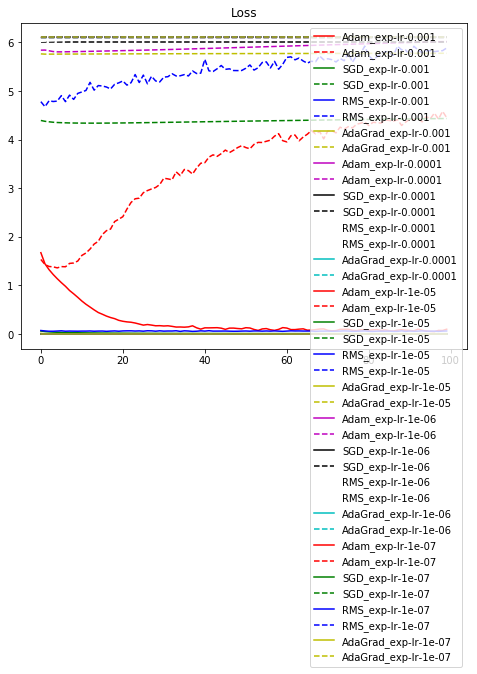

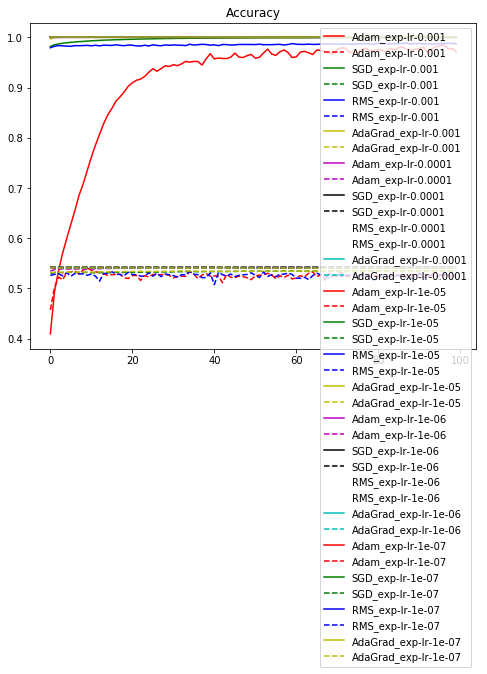

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","w","c"]

print(results.keys())
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
plt.title("Accuracy")
plt.legend()
plt.show()